# EDA (Exploratory Data Analysis)

Luego del proceso de Extracción, Transformación y Carga (ETL) que culminó en la creación del archivo __"siniestros_limpios.csv"__, procederemos al Análisis Exploratorio de Datos (EDA) que no es más que un acto de inmersión en el compendio completo de eventos trágicos que queremos explorar y entender a fondo.

Durante el EDA, nos sumergimos en este conjunto de datos para comprender su estructura, abordar posibles outliers, identificar duplicados y gestionar valores faltantes. La riqueza de este análisis radica en la capacidad de revelar patrones, tendencias y relaciones entre variables, todo respaldado por visualizaciones pertinentes. A través de este proceso, buscamos extraer información valiosa que impulse futuras investigaciones y acciones relacionadas con la seguridad vial en la Ciudad de Buenos Aires - Argentina.

### Importar librerías necesarias

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sketch
import geopandas as gpd
from shapely.geometry import Point, Polygon
import geojson
import folium
from folium.plugins import HeatMap
from summarytools import dfSummary

### Ruta del archivo

En la etapa inicial de nuestro proceso, abordamos el archivos original 'homicidios.xlsx', compuesto por dos hojas de datos: HECHOS y VICTIMAS. Durante la fase de Extracción, Transformación y Carga (ETL), optamos por fusionar estas hojas mediante un merge, generando así un archivo resultante: 'siniestros_limpio.csv'. Este archivos han sido sometidos a un proceso exhaustivo de tratamiento y limpieza de datos.


In [2]:
df= pd.read_csv("siniestos_limpio.csv")
df.head(3)

,Id,Fecha,Año,Mes,Día,Día semana,Hora completa,Hora,Num víctimas,Participantes,...,Calle,Cruce,Dirección normalizada,Comuna,Barrios,Xy (caba),Coordenada x,Coordenada y,Pos x,Pos y
0,2016-0001,2016-01-01,2016.0,1.0,1.0,Viernes,04:00:00,4.0,1,MOTO-AUTO,...,PIEDRA BUENA AV.,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",Comuna 8,VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI,Point (98896.78238426 93532.43437792),98896.782384,93532.434378,-58.475340,-34.687570
1,2016-0002,2016-01-02,2016.0,1.0,2.0,Sabado,01:15:00,1.0,1,AUTO-PASAJEROS,...,"PAZ, GRAL. AV.",DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",Comuna 9,LINIERS - MATADEROS - PARQUE AVELLANEDA,Point (95832.05571093 95505.41641999),95832.055711,95505.416420,-58.508775,-34.669777
2,2016-0003,2016-01-03,2016.0,1.0,3.0,Domingo,07:00:00,7.0,1,MOTO-AUTO,...,ENTRE RIOS AV.,NaN,ENTRE RIOS AV. 2034,Comuna 1,CONSTITUCION - MONTSERRAT - PUERTO MADERO - RE...,Point (106684.29090040 99706.57687843),106684.290900,99706.576878,-58.390403,-34.631894


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     717 non-null    object 
 1   Fecha                  702 non-null    object 
 2   Año                    702 non-null    float64
 3   Mes                    702 non-null    float64
 4   Día                    702 non-null    float64
 5   Día semana             702 non-null    object 
 6   Hora completa          702 non-null    object 
 7   Hora                   701 non-null    float64
 8   Num víctimas           717 non-null    int64  
 9   Participantes          702 non-null    object 
 10  Rol                    717 non-null    object 
 11  Acusado                702 non-null    object 
 12  Victima                702 non-null    object 
 13  Sexo                   717 non-null    object 
 14  Edad                   717 non-null    int64  
 15  Rango 

### Outliers

Se realiza la busqueda de datos con valores atípicos en las features, y se analiza si es necesario eliminarlos.

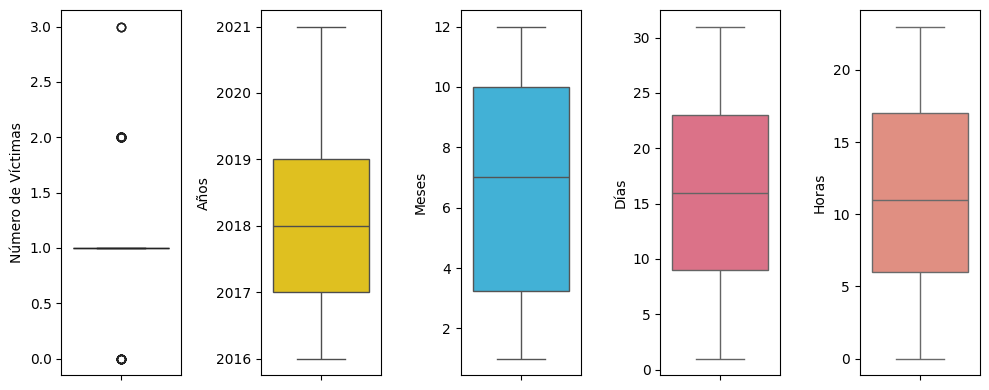

In [4]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(10, 4))

# Crear subplots para los gráficos 
plt.subplot(1, 5, 1) 
sns.boxplot(data=df, y='Num víctimas', color = "#3C3C3B")
plt.ylabel('Número de Víctimas')

plt.subplot(1, 5, 2) 
sns.boxplot(data=df, y='Año', color = "#FFD500")
plt.ylabel('Años')

plt.subplot(1, 5, 3) 
sns.boxplot(data=df, y='Mes', color = "#29BDEF")
plt.ylabel('Meses')

plt.subplot(1, 5, 4) 
sns.boxplot(data=df, y='Día', color = "#EC607E")
plt.ylabel('Días')

plt.subplot(1, 5, 5) 
sns.boxplot(data=df, y='Hora', color = "#F08372")
plt.ylabel('Horas')

# Ajustar espaciado entre subplots
plt.tight_layout()

plt.show()

__Conclusión:__

Los Outliers que se encuentran en feature Num víctimas (valores 2 ó 3), se producen debido a que en la mayoria de los casos el registro es el valor uno (1); con respecto a las victimas en los siniestros.

__A - Variables Númericas__

En el dataset hay variables numéricas ó que contienen números; pero su utilización como tales va a depender del contexto de los datos. En éste caso se utiliza un mapa de correlaciones para examinar si existen, relaciones entre los datos númericos ó se utilizarán como categóricos (en algunos casos), para el correcto análisis

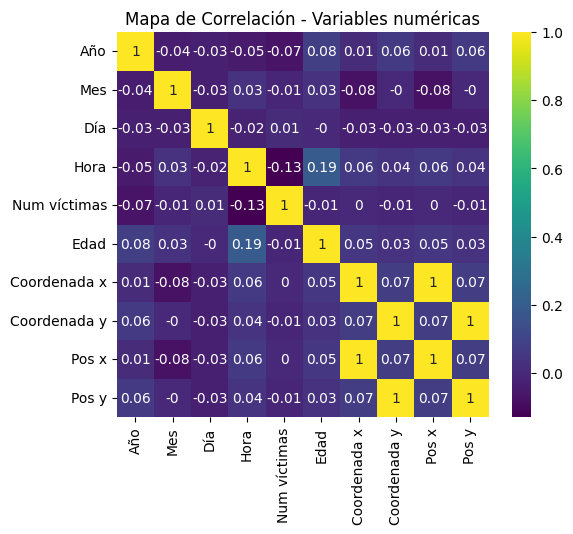

In [5]:
# Generamos un mapa de calor con las correlaciones de los todos los datos que contengan números 
dataNumerica = df.select_dtypes(include=['number']) 
corr = dataNumerica.corr().round(2)

plt.figure(figsize=(6,5))
sns.heatmap(corr, cmap="viridis", annot=True)
plt.title('Mapa de Correlación - Variables numéricas')
plt.show()

El cruzamiento de todas las variables numéricas en la matriz resulta con relaciones positivas fuertes entre las features Coordenada y Pos, lo que resultaría un dato esperable. Se puede verificar también una correlacíon positiva leve entre la variable Edad y Hora Las demás correlaciones son negativas, hecho que se esperaba debido a que el Num víctimas de un siniestro no se vincula a una fecha u hora puntual.

Debido al objetivo de éste proyecto, que consiste en analizar los siniestros, con el fin de disminuir la cantidad de víctimas fatales; se define comenzar la exploración con la variable Num víctimas.

    Num víctimas


- Cantidad de víctimas fatales por siniestro vial

In [6]:
df["Num víctimas"].describe()

count    717.000000
mean       1.037657
std        0.294226
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: Num víctimas, dtype: float64

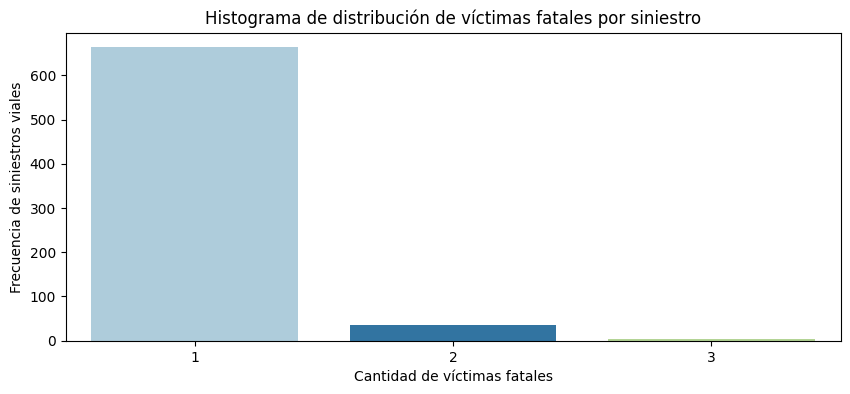

In [7]:
plt.figure(figsize=(10, 4))
# se filtran los valores sin datos o nulos 
df_filtrado = df[df["Num víctimas"] != 0]

# Se cuentan los datos de la columna y se calcula la frecuencia en que se distribuye
sns.countplot(x='Num víctimas', data=df_filtrado, palette="Paired", hue='Num víctimas', legend=False)

plt.ylabel("Frecuencia de siniestros viales")
plt.xlabel("Cantidad de víctimas fatales")
plt.title("Histograma de distribución de víctimas fatales por siniestro")

plt.show()


__Conclusión__
- La cantidad de víctimas fatales que arrojan los siniestros viales es de 1 (una), en la mayoría de los casos.
- Según los datos estadísticos de la columna el 75% de los siniestros viales tienen 1 víctima.
- Rara vez resulta un siniestro con tres víctimas fatales

### Relación Num víctimas con el tiempo - Distribución temporal

Se analizan los datos teniendo en cuenta diferentes horizontes temporales, para corroborar la existencia de algún tipo de evento o patrón importante.

In [8]:
# Agrupar por año, mes y sumar el número de víctimas.

rel_tiempo = df.groupby(['Año', 'Mes'])['Num víctimas'].sum().reset_index()
rel_tiempo

,Año,Mes,Num víctimas
0,2016.0,1.0,8
1,2016.0,2.0,12
2,2016.0,3.0,15
3,2016.0,4.0,9
4,2016.0,5.0,7
...,...,...,...
67,2021.0,8.0,9
68,2021.0,9.0,4
69,2021.0,10.0,5
70,2021.0,11.0,8


In [9]:
# Para la realización de los graficos se transforman los datos a tipo int

rel_tiempo['Año'] = rel_tiempo['Año'].astype('int64')
rel_tiempo['Mes'] = rel_tiempo['Mes'].astype('int64')

In [10]:
rel_tiempo

,Año,Mes,Num víctimas
0,2016,1,8
1,2016,2,12
2,2016,3,15
3,2016,4,9
4,2016,5,7
...,...,...,...
67,2021,8,9
68,2021,9,4
69,2021,10,5
70,2021,11,8


In [11]:
# Combinar 'Año' y 'Mes' para obtener una sola variable de Tiempo, creando una columna 'FECHA' de tipo str
rel_tiempo['Fecha'] =  rel_tiempo['Año'].astype(str) + '-' + rel_tiempo['Mes'].astype(str)

# Convertir la variable de tiempo a datatime

rel_tiempo['Fecha'] = pd.to_datetime(rel_tiempo['Fecha'])

# Ordenar el DataFrame por fecha para que tenga un orden cronológico

rel_tiempo = rel_tiempo.sort_values('Fecha')


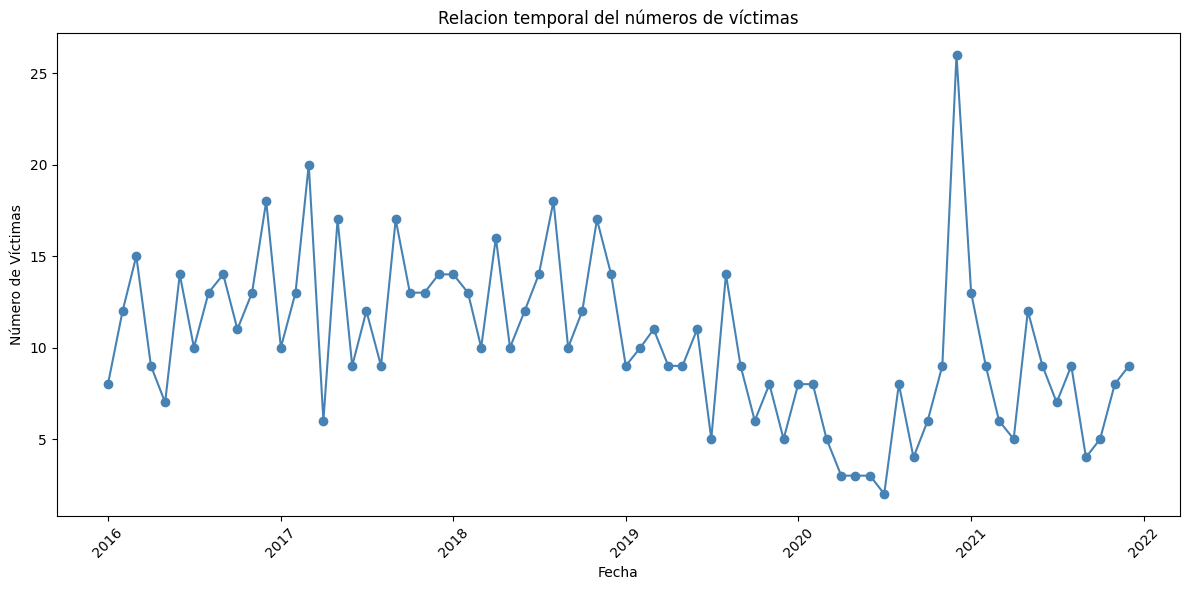

In [12]:
# Crear el grafico de linea
plt.figure(figsize=(12,6))
plt.plot(rel_tiempo["Fecha"], rel_tiempo["Num víctimas"], marker='o', color='steelblue')

# Añadir títulos y etiquetas
plt.title('Relacion temporal del números de víctimas')
plt.xlabel('Fecha')
plt.ylabel('Número de Víctimas')

# Rotar las etiquetas del eje x para mejorar la visualización
plt.xticks(rotation=45)

# Mostar el Gráfico
plt.tight_layout()
plt.show()

__Conclusión__

- En el gráfico de la relación temporal del número de víctimas, se muestra como las fechas con mayor cantidad de siniestros fatales se dan durante 2017 y 2018; luego se percibe una disminución sostenida en los siguientes años. Sólo hubo un pico, a finales de 2020 superando el mayor número de víctimas mesuales a lo largo de los años analizados (26 víctimas fatales).
- Durante el año 2020, la llegada de la pandemia COVID19; influyó notablemente en las estadísticas de siniestros viales

### Distribución temporal de víctimas

__Distribución mensual de víctimas fatales__

Se crea un gráfico de barras que muestra la cantidad de víctimas por mes y agrega etiquetas de número de víctimas en cada barra.

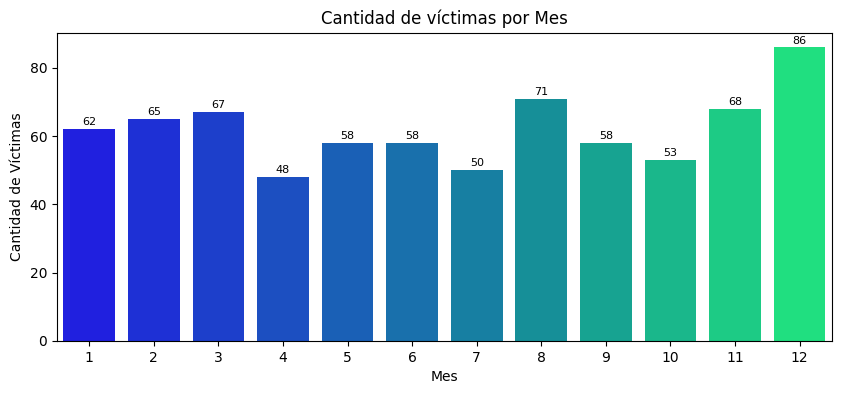

In [13]:
# Se agrupa por la cantidad de víctimas por mes
data = df.groupby(['Mes'])['Num víctimas'].sum().reset_index()
data["Mes"] = data["Mes"].astype("Int64")

# Se grafica
plt.figure(figsize=(10, 4))

ax = sns.barplot(x='Mes', y='Num víctimas', data=data, hue='Mes', palette="winter", dodge=False, legend=False)
ax.set_title('Cantidad de víctimas por Mes')
ax.set_xlabel('Mes')
ax.set_ylabel('Cantidad de Víctimas')

# Agregar etiquetas de número de víctimas en cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

# Se muestra el gráfico
plt.show()


__Distribución diaria de víctimas fatales__

Se crea un gráfico de barras que muestra la cantidad de víctimas por día y agrega etiquetas de número de víctimas en cada barra.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18020\1333812525.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Día', y='Num víctimas', data=data, palette="winter", dodge=False, legend=False)


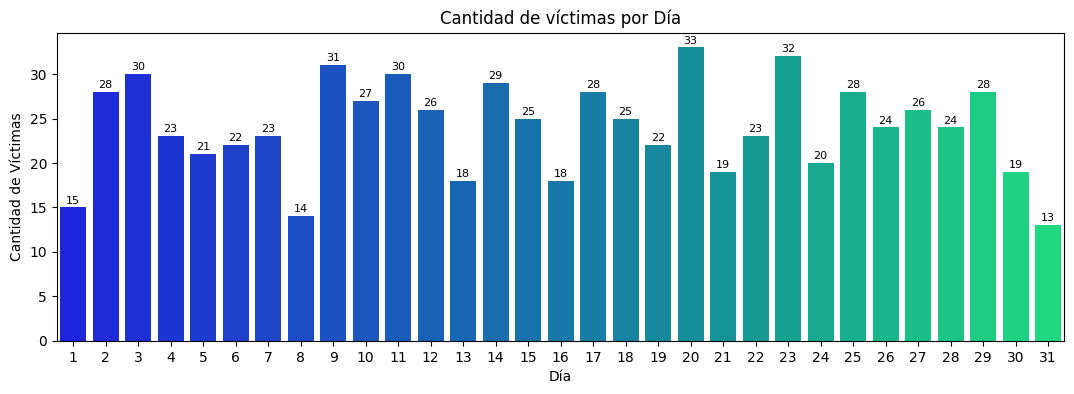

In [14]:
# Se agrupa la cantidad de víctimas por día
data = df.groupby(['Día'])['Num víctimas'].sum().reset_index()
data["Día"] = data["Día"].astype("Int64")

# Se grafica
plt.figure(figsize=(13, 4))

ax = sns.barplot(x='Día', y='Num víctimas', data=data, palette="winter", dodge=False, legend=False)
ax.set_title('Cantidad de víctimas por Día')
ax.set_xlabel('Día')
ax.set_ylabel('Cantidad de Víctimas')

# Agregar etiquetas de número de víctimas en cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

# Se muestra el gráfico
plt.show()


Se crea un gráfico de barras que muestra la cantidad de víctimas por día de la semana y agrega etiquetas de número de víctimas en cada barra.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18020\2999282100.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Día semana', y='Num víctimas', data=data, palette="winter")


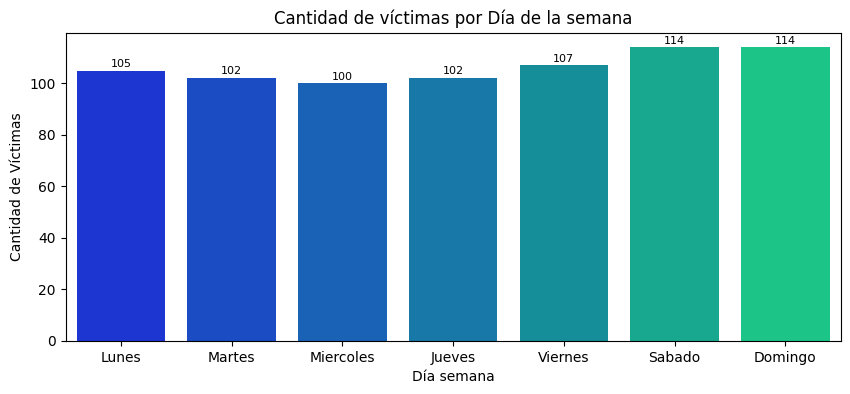

In [15]:
# Se agrupa por la cantidad de víctimas por dia semana
data = df.groupby(['Día semana'])['Num víctimas'].sum().reset_index()


# Define el orden de los días de la semana
orden_dias_semana = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]

# Crea una columna 'Orden_dia_semana' en el DataFrame para representar el orden numérico de los días de la semana
data['Orden_dia_semana'] = data['Día semana'].apply(lambda x: orden_dias_semana.index(x))

# Ordena el DataFrame según el orden numérico de los días de la semana
data = data.sort_values(by='Orden_dia_semana')



# Se grafica
plt.figure(figsize=(10,4))

ax = sns.barplot(x='Día semana', y='Num víctimas', data=data, palette="winter")
ax.set_title('Cantidad de víctimas por Día de la semana')
ax.set_xlabel('Día semana') ; ax.set_ylabel('Cantidad de Víctimas')

# Agregar etiquetas de número de víctimas en cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

# Se muestra el gráfico
plt.show()

__Distribución relacionando horas y días, de víctimas fatales__

Se crea un mapa de calor donde el eje x representa las horas del día, el eje y representa los días de la semana y el color de cada celda indica el número de víctimas. Se utiliza Seaborn para crear el mapa de calor y el argumento annot=True agrega los valores numéricos en las celdas del mapa de calor.

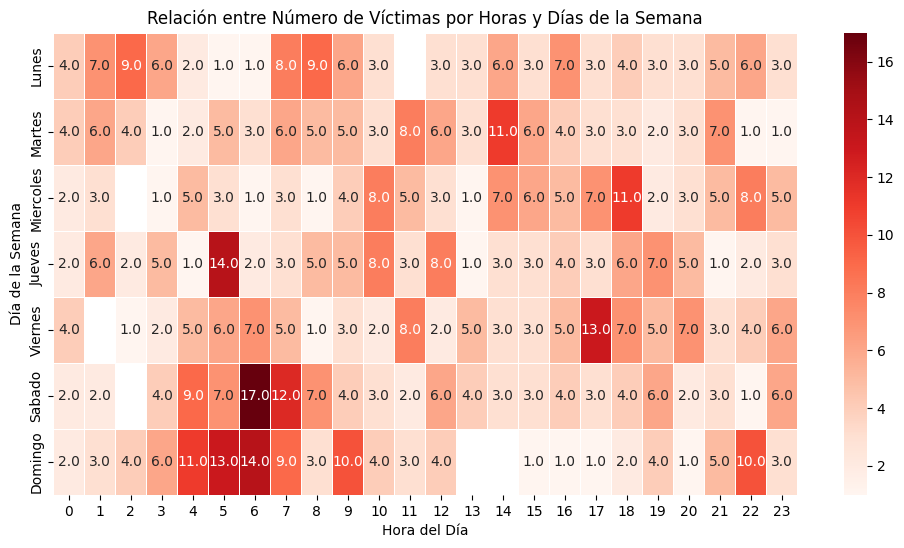

In [54]:
#Agrupa los datos en cantidad de victimas por dia de la semana y horas 
data = df.groupby(['Día semana', "Hora"])['Num víctimas'].sum().reset_index()
data["Hora"]=data["Hora"].astype("Int64")

# Define el orden de los días de la semana
orden_dias_semana = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]

# Crea una columna 'Orden_dia_semana' en el DataFrame para representar el orden numérico de los días de la semana
data['Orden_dia_semana'] = data['Día semana'].apply(lambda x: orden_dias_semana.index(x))

# Ordena el DataFrame según el orden numérico de los días de la semana
data = data.sort_values(by='Orden_dia_semana')

# Crear una tabla pivot para los datos
pivot_data = data.pivot_table(index= 'Día semana', columns='Hora', values='Num víctimas', aggfunc='sum')
pivot_data = pivot_data.reindex(orden_dias_semana)

# Crear un mapa de calor (heatmap) con colores personalizados
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, cmap='Reds', annot=True, fmt='.1f', linewidths=0.5)

# Configurar etiquetas y título
plt.xlabel('Hora del Día')
plt.ylabel('Día de la Semana')
plt.title('Relación entre Número de Víctimas por Horas y Días de la Semana')

# Mostrar el gráfico
plt.show()

__Conclusión__

- El mes con mayor cantidad de víctimas fatales (86) es Diciembre .
- El Día 20 de cada mes es el que lleva el mayor número de víctimas y los días Sábado y Domingo tienen la suma de 114 víctimas fatales, siendo la mayor cantidad.
- El mapa de calor indica que los días de fin de semana, en especial sábados y domingos se encuentran con un número más alto de víctimas fatales, siendo las horas entre 03.00 hs y 09.00 hs
- Puede decirse que los horarios con mayor peligrosidad tienen que ver con el ingreso laboral (05:00 hs - 09:00 hs), el horario del mediodía (12:00 hs - 14:00 hs) y salida del trabajo (17:00 hs  18:00 hs). Durante la madrugada existen pocos siniestros. Y los fines de semana los la cantidad de siniestros es poca pero con mayor cantidad de víctimas

    Edad de las víctimas

Se crea un histograma de edades de las víctimas fatales y se utiliza el mismo eje para mostrar las estadísticas de la columna edades a través de un boxplot

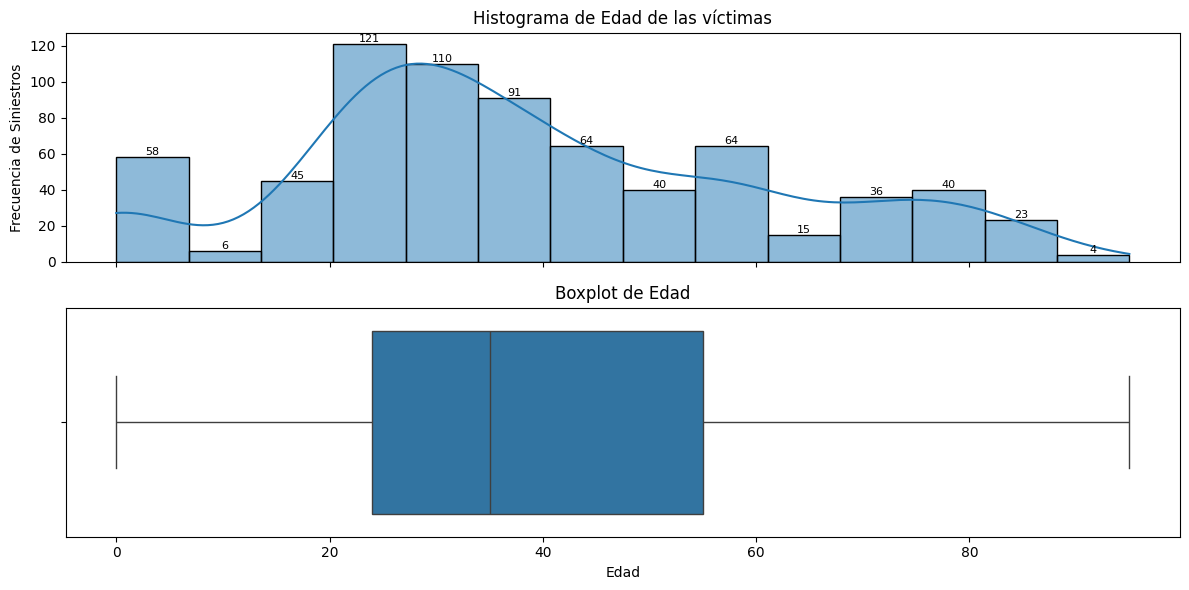

In [17]:
# Se crea una figura con un solo eje x compartido para tener dos gráficos en uno
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Se grafica el histograma de la edad
sns.histplot(df['Edad'], kde=True, ax=ax[0]) #se agrega la línea de suavizado
ax[0].set_title('Histograma de Edad de las víctimas') ; ax[0].set_ylabel('Frecuencia de Siniestros')

# Agregar etiquetas de datos en el histograma
for p in ax[0].patches:
    ax[0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=8, color='black')

# Se grafica el boxplot de la edad
sns.boxplot(x=df['Edad'], ax=ax[1])
ax[1].set_title('Boxplot de Edad') ; ax[1].set_xlabel('Edad')

# Se ajusta y muestra el gráfico
plt.tight_layout()
plt.show()

In [18]:
df["Edad"].describe()

count    717.000000
mean      39.050209
std       22.010669
min        0.000000
25%       24.000000
50%       35.000000
75%       55.000000
max       95.000000
Name: Edad, dtype: float64

En una visualización en general se puede observar que el 75% de las víctimas fatales es menor que 55 años, la mediana es de 39 años. Con respecto a la distribución del histograma, puede concluirse que la mayor cantiad de víctimas fatales se concentra entre los 20 a 40 años de edad

__Relación de Edad de las víctimas con la Hora del siniestro__

Se realiza el análisis de ésta relación que resultó positiva en la matriz de correlación en las variables numéricas. Se crea un gráfico de dispersión que representa la relación entre la edad de las víctimas en el eje x y la hora del siniestro en el eje y.

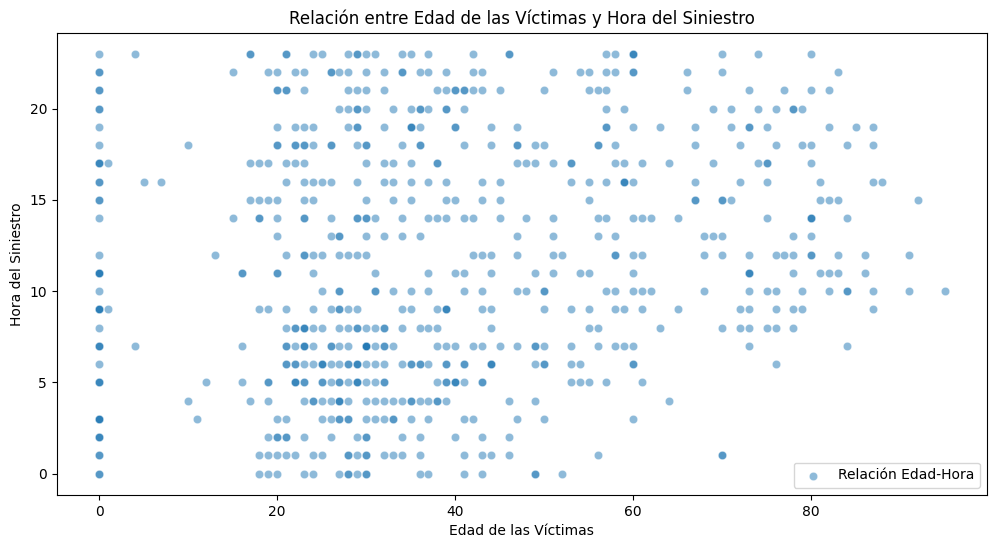

In [19]:
#Agrupa los datos en cantidad de victimas por edad y horas 
data = df.groupby(['Edad', "Hora"])['Num víctimas'].sum().reset_index()
data["Edad"]=data["Edad"].astype("Int64")
data["Hora"]=data["Hora"].astype("Int64")



# Crear un gráfico de dispersión para la relación entre edad y hora
plt.figure(figsize=(12, 6))

sns.scatterplot(data=df, x='Edad', y='Hora', alpha=0.5, label='Relación Edad-Hora') # se utiliza alpha para transparencia de los puntos
plt.xlabel('Edad de las Víctimas')
plt.ylabel('Hora del Siniestro')
plt.title('Relación entre Edad de las Víctimas y Hora del Siniestro')

# Agregar una leyenda
plt.legend(loc='best') 
# Mostrar el gráfico
plt.show()

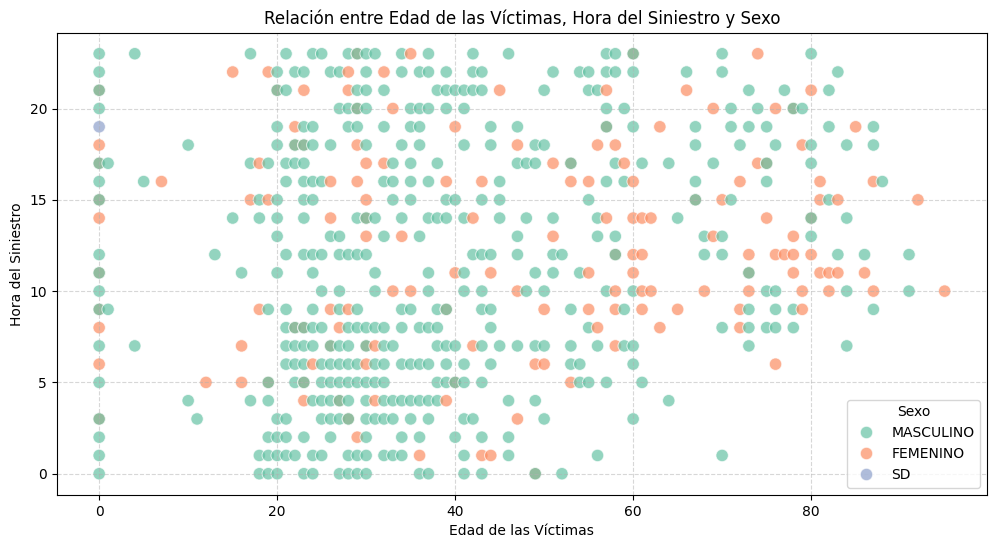

In [61]:
# Agrupa los datos en cantidad de víctimas por edad, horas y sexo
data = df.groupby(['Edad', "Hora", "Sexo"])['Num víctimas'].sum().reset_index()
data["Edad"]=data["Edad"].astype("Int64")
data["Hora"]=data["Hora"].astype("Int64")

# Crear un gráfico de dispersión para la relación entre edad, hora y sexo
plt.figure(figsize=(12, 6))

# Cambiar la paleta de colores y el tamaño de los puntos
sns.scatterplot(data=data, x='Edad', y='Hora', hue='Sexo', alpha=0.7, palette='Set2', s=80)

# Agregar etiquetas a los ejes
plt.xlabel('Edad de las Víctimas')
plt.ylabel('Hora del Siniestro')
plt.title('Relación entre Edad de las Víctimas, Hora del Siniestro y Sexo')

# Agregar una leyenda
plt.legend(title='Sexo')

# Cambiar el estilo de la cuadrícula
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()


__Conclusión__

- Las gráficas de dispersión presentadas arriba, señalan la relación entre las edades de 20 a 40 años de las víctimas y las horas de mayor cantidad de ocurrencia de siniestros viales; siendo entre las 5 a 9 hs y 17 a 18 hs
- Cuando se le agrega la distinción por Sexo, se muestra una mayor cantidad de víctimas Masculinas, con respecto a las Femeninas en ésta relación

__Distribución etaria de víctimas según Sexo__

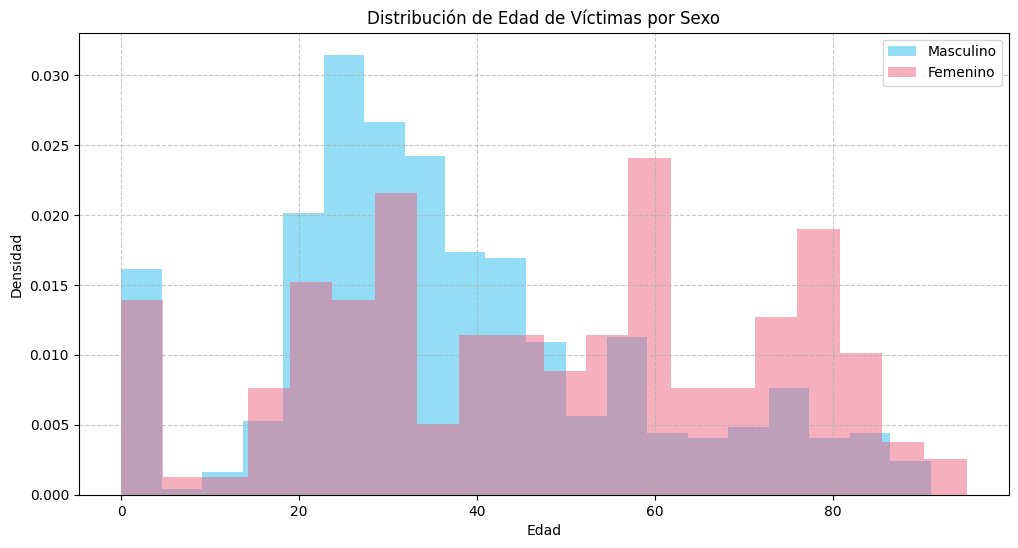

In [58]:
# Filtrar por sexo masculino
masculino = df[df['Sexo'] == 'MASCULINO']['Edad'].dropna()

# Filtrar por sexo femenino
femenino = df[df['Sexo'] == 'FEMENINO']['Edad'].dropna()

# Crear el histograma con colores y estilo diferente
plt.figure(figsize=(12, 6))
plt.hist(masculino, bins=20, alpha=0.5, color='#29BDEF', label='Masculino', density=True)
plt.hist(femenino, bins=20, alpha=0.5, color='#EC607E', label='Femenino', density=True)
plt.title('Distribución de Edad de Víctimas por Sexo')
plt.xlabel('Edad')
plt.ylabel('Densidad')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)  # Añadir líneas de cuadrícula punteadas
plt.show()


__Conclusión__

El gráfico muestra dos histogramas sobre el mismo eje a fin de poder comparar de manera más visual la diferencia entre las víctimas de ambos sexos.

- Como resultado arroja que las victimas de sexo Masculino son de 20 a 40 años de Edad
- Las víctimas de sexo Femenino son de entre 40, 60 y 80 años de Edad.

__Distribución temporal de las Edades de las víctimas__

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18020\2034789037.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Año', y='Edad', data=df, palette="winter")


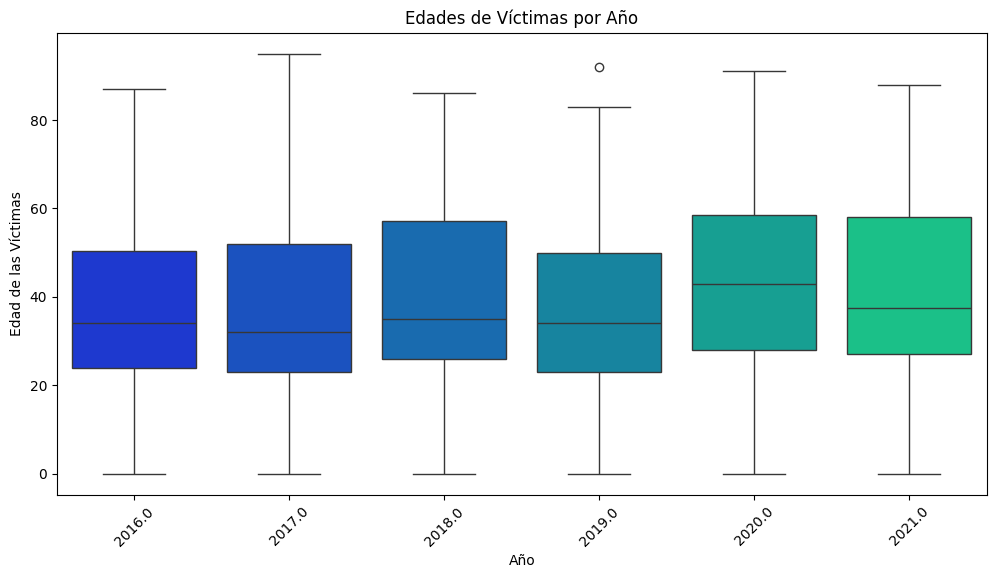

In [22]:
#Agrupa los datos en cantidad de victimas por edad y  año
data = df.groupby(['Edad', "Año"])['Num víctimas'].sum().reset_index()


#Se crea el gráfico de boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Año', y='Edad', data=df, palette="winter")

plt.title('Edades de Víctimas por Año') ; plt.xlabel('Año') ; plt.ylabel('Edad de las Víctimas')
# Cambia el formato de las etiquetas del eje x a enteros
plt.xticks(rotation=45)
# Se muestra el gráfico
plt.show()

__Conclusión__

El gráfico confirma que a través del tiempo, la mediana de la edad de las víctimas sigue siendo alrrededor de los 39 años y supera esta barrera en el año 2020

__Distribución espacial de los siniestros con víctimas Coordenadas__

Para usar Geopandas, primero se define un sistema de referencia de coordenadas (CRS) y éste le dice a Python como se relacionan estas coordenadas que instanciamos con los diferentes lugares del planeta

In [23]:
# Iniciamos CRS

crs={'init':'epsg:4326'}

In [24]:
#Definimos la geometría según nuestro dataset
geometry=[Point(xy) for xy in zip(df["Pos x"], df["Pos y"])]

c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Axes: >

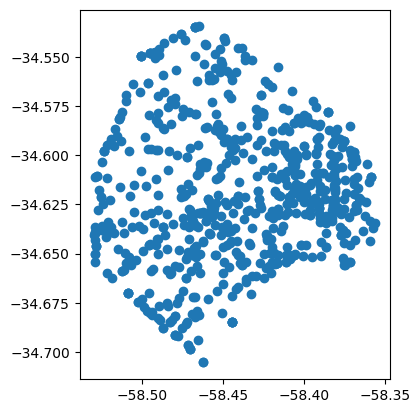

In [25]:
#Ua vez que tenemos el sistema de referencia decoordenadas y la geometría; se procede a la carga de los datos
geodata=gpd.GeoDataFrame(df,crs=crs, geometry=geometry)

#Se imprime el resultante que luego será introducido en un mapa
geodata.plot()

Una vez que el mapa de geometría está listo, se debe cargar el archivo de las comunas del la ciudad de Buenos Aires que se extrajo de https://data.buenosaires.gob.ar/dataset/comunas/resource/Juqdkmgo-612222-resource que debe ser un archivo Shapefile (SHP)

In [26]:
#Extraer el archivo
shapefile = gpd.read_file(r"comunas_wgs84.shp")

Text(158.98305973900304, 0.5, 'Latitud')

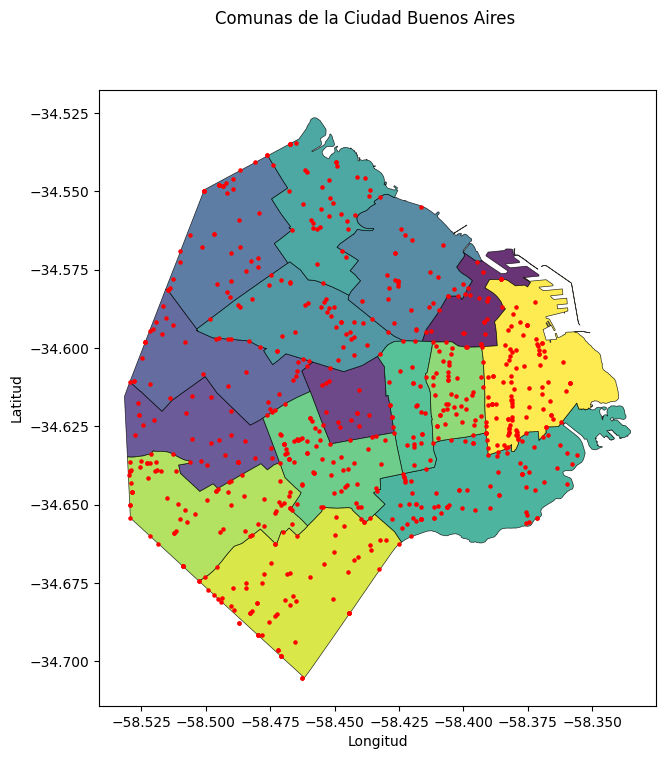

In [27]:
#Se realiza sobre el mapa de CABA la presentación de los puntos de referencia a los siniestros viales

#Crea ejes y figuras
fig, ax = plt.subplots(figsize=(10,8))

#Dibujar el Shapefile
shapefile.plot(ax=ax, facecolor='Grey', edgecolor='k',alpha=0.8,linewidth=0.5,cmap="viridis")

#Dibujar los datos geoespaciales
geodata.plot(ax=ax, color='red', markersize=5);

#Agregar título y etiquetas de ejes
fig.suptitle('Comunas de la Ciudad Buenos Aires', fontsize=12)
ax.set_xlabel('Longitud', fontsize=10)
ax.set_ylabel('Latitud', fontsize='medium')

__Conclusión__

- La gráfica muestra la concentración de los puntos rojos representando siniestros con víctimas fatales, hacia la zona Este del mapa de CABA sobre la comuna 1 y 4

### B - Variables Categóricas

__Distribución por Comuna__

In [28]:
#Se crea un dataset con el número de víctimas por Barrio y Comuna
Total_comuna=df.groupby(["Comuna", "Barrios"])["Num víctimas"].sum().reset_index()
Total_comuna=Total_comuna.sort_values(by="Num víctimas", ascending=False)
Total_comuna

,Comuna,Barrios,Num víctimas
0,Comuna 1,CONSTITUCION - MONTSERRAT - PUERTO MADERO - RE...,101
9,Comuna 4,BARRACAS - BOCA - NUEVA POMPEYA - PARQUE PATRI...,81
14,Comuna 9,LINIERS - MATADEROS - PARQUE AVELLANEDA,74
13,Comuna 8,VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI,70
12,Comuna 7,FLORES - PARQUE CHACABUCO,65
8,Comuna 3,BALVANERA - SAN CRISTOBAL,48
6,Comuna 15,AGRONOMIA - CHACARITA - PARQUE CHAS - PATERN...,47
3,Comuna 12,COGHLAN - SAAVEDRA - VILLA PUEYRREDON - VILLA ...,43
4,Comuna 13,BELGRANO - COLEGIALES - NUÃ‘EZ,39
5,Comuna 14,PALERMO,38


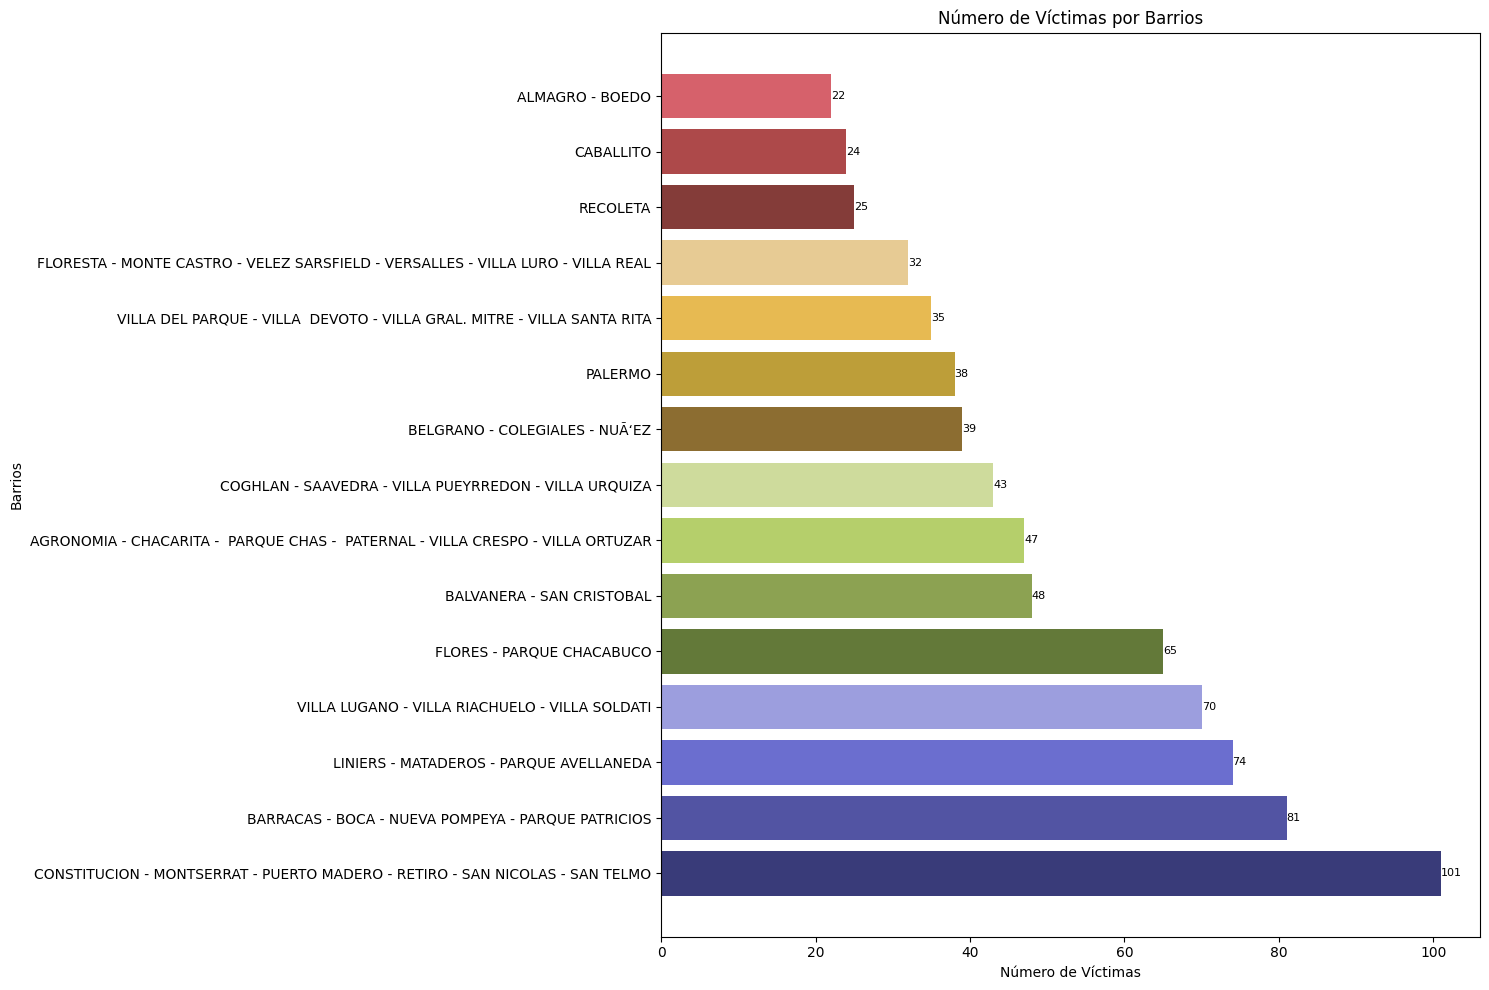

In [29]:
# Crear el gráfico de barras horizontales
plt.figure(figsize=(15, 10))

# Colores para las barras
colores = plt.cm.tab20b(range(len(Total_comuna)))

# Dibujar las barras horizontales
plt.barh(Total_comuna["Barrios"], Total_comuna["Num víctimas"], color=colores)

# Etiquetas de eje x e y
plt.xlabel('Número de Víctimas')
plt.ylabel('Barrios')

# Título del gráfico
plt.title('Número de Víctimas por Barrios')

# Agregar el número de víctimas sobre cada barra
for i, v in enumerate(Total_comuna["Num víctimas"]):
    plt.text(v, i, str(v), va='center', fontsize=8, color='black')


plt.tight_layout()
plt.show()


__Conclusión__

- El dataset presenta el total de 15 comunas que conforman los distintos barrios de CABA. Cada comuna esta formada por uno o varios Barrios.
- De la tabla Total_comunas resultan con mayor cantidad de víctimas fatales las Comunas 1, 4, 9, 8 y 7.
- La comuna 1 supera por 20 en víctimas a la comuna 4, que le sigue en orden

Ello sugiere que pueden ser Barrios donde existan arterias muy transitadas al momento de la entrada ó salida del horario laboral

__Distribución de los Tipos de Calles donde suceden los siniestros__

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18020\713621936.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(df, x='Tipo de calle', palette="winter")


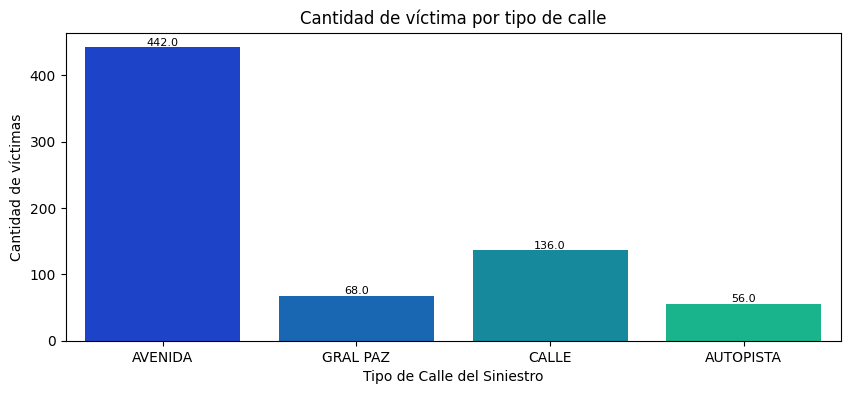

In [30]:
#Se crea el gráfico de barras
plt.figure(figsize=(10, 4))

ax=sns.countplot(df, x='Tipo de calle', palette="winter")

# Agrega el número de víctimas en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=8)

#Se titulan los ejes
plt.xlabel('Tipo de Calle del Siniestro')
plt.ylabel('Cantidad de víctimas')
plt.title('Cantidad de víctima por tipo de calle')

plt.show()

__Conclusión__

- Del análisis del gráfico resulta que el mayor número de víctimas fatales se producen en Avenida; secundado por Calle.

__Distribución de Participantes en los siniestros__

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18020\3601797418.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(df, x="Participantes", palette="winter")


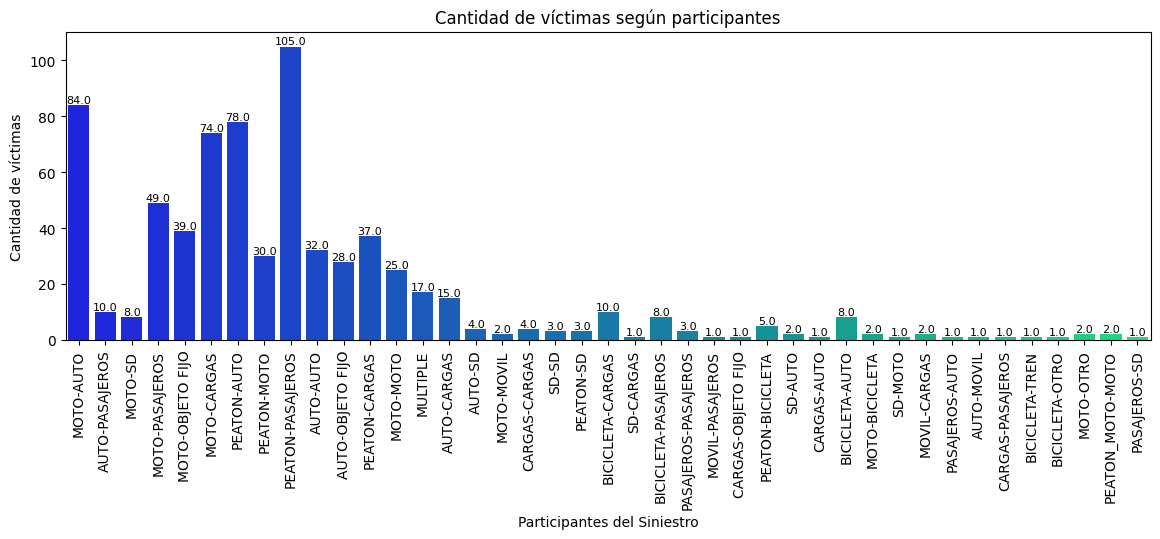

In [31]:
#Se crea el gráfico de barras
plt.figure(figsize=(14, 4))

ax=sns.countplot(df, x="Participantes", palette="winter")

# Agrega el número de víctimas en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=8)

#Se ubican los titulos de las barras en 90 grados
plt.xticks(rotation=90)

#Se titulan los ejes
plt.xlabel('Participantes del Siniestro')
plt.ylabel('Cantidad de víctimas')
plt.title('Cantidad de víctimas según participantes')

plt.show()

__Conclusión__

- Los valores de participación que concentran más víctimas están en PEATON-PASAJEROS, esto según el diccionario de datos, se refiere a Peatón: es cualquier víctima distinta de cualquier ocupante de un vehículo; Pasajero: es cualquier persona que se encuentra dentro, descendiendo o ascendiendo del transporte público u omnibús de larga distancia.
- Le siguen en importancia de víctimas MOTO-AUTO , PEATON-AUTO y MOTO-CARGAS

En la columna Participantes puede interpretarse que la primer palabra se relaciona a quien fue la Víctima y la segunda palabra se refiere al Acusado

__Distribución de Acusados en los siniestros__

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18020\2202415886.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(df, x="Acusado", palette="winter")


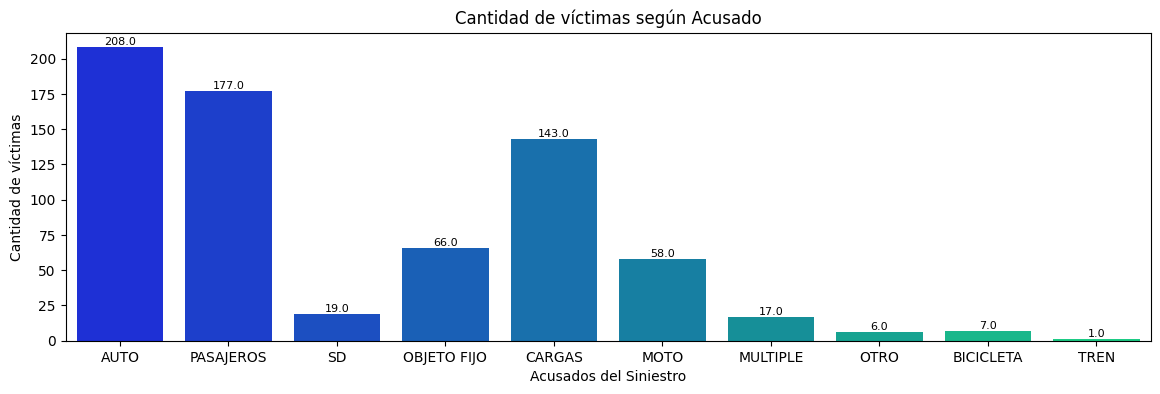

In [32]:
#Se crea el gráfico de barras
plt.figure(figsize=(14, 4))

ax=sns.countplot(df, x="Acusado", palette="winter")

# Agrega el número de víctimas en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=8)


#Se titulan los ejes
plt.xlabel('Acusados del Siniestro')
plt.ylabel('Cantidad de víctimas')
plt.title('Cantidad de víctimas según Acusado')

plt.show()

__Conclusión__

- Se puede visualizar que los que causan más víctimas son los Autos, Cargas y Pasajeros. Esto se relaciona con el punto anterior.

__Distribución de Víctimas en los siniestros__

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18020\3606964637.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(df, x="Victima", palette="winter")


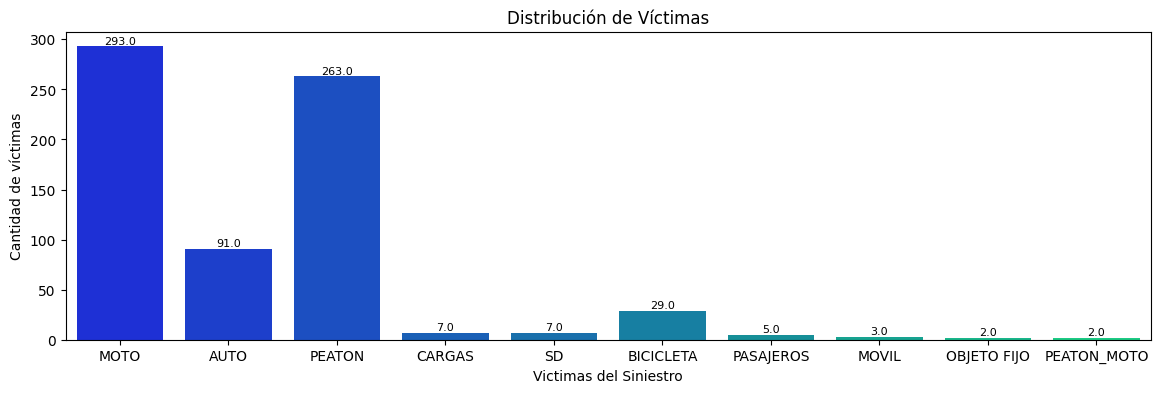

In [33]:
#Se crea el gráfico de barras
plt.figure(figsize=(14, 4))

ax=sns.countplot(df, x="Victima", palette="winter")

# Agrega el número de víctimas en las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=8)


#Se titulan los ejes
plt.xlabel('Victimas del Siniestro')
plt.ylabel('Cantidad de víctimas')
plt.title('Distribución de Víctimas')

plt.show()

__Conclusión__

- Se puede visualizar que las víctimas son Moto, Peaton y Carga. Esto se relaciona con ambos puntos anteriores.

__Matriz de confusión__

Se crea una tabla ce contingencia que relacione los datos de las columnas Víctima y Acusado para analizar de manera más visual los datos de los siniestros y sus participantes.

In [34]:
tabla_contingencia = pd.crosstab(df['Victima'], df['Acusado'])

# Visualizar la tabla de contingencia
tabla_contingencia

Acusado,AUTO,BICICLETA,CARGAS,MOTO,MULTIPLE,OBJETO FIJO,OTRO,PASAJEROS,SD,TREN
Victima,,,,,,,,,,
AUTO,32,0,15,0,3,26,1,10,4,0
BICICLETA,8,0,10,0,1,0,1,8,0,1
CARGAS,1,0,4,0,0,1,0,1,0,0
MOTO,84,2,74,25,8,39,4,49,8,0
MOVIL,0,0,2,0,0,0,0,1,0,0
OBJETO FIJO,2,0,0,0,0,0,0,0,0,0
PASAJEROS,1,0,0,0,0,0,0,3,1,0
PEATON,78,5,37,30,5,0,0,105,3,0
PEATON_MOTO,0,0,0,2,0,0,0,0,0,0


__Conclusión__

Aquí se encuentran de manera más clara en sus resultados la intervención en cada siniestro.

- Cuando el acusado es Auto, la mayoría de las víctimas son Autos, Motos y Peatones.
- Cuando el acusado es Cargas, las victimas son variadas; siendo Motos y Peatones los más encontrados.
- Cuando el acusado es Pasajeros, las víctimas son principalmente Peatones y Motos.

La frecuencia de víctimas Motos y Peatones es alta, y se relacionan con casi todos los tipos de Acusados.

__Proporción de víctimas por Sexo__

Text(0.5, 1.0, 'Proporción de Víctimas por Sexo')

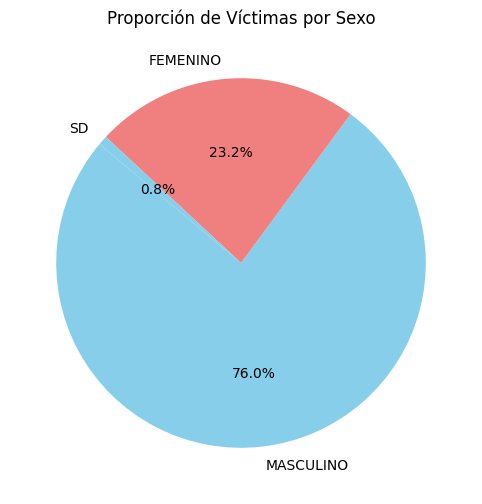

In [35]:
# Calcular la proporción de víctimas por sexo
proporcion = df['Sexo'].value_counts(normalize=True) * 100

# Preparar los datos para el gráfico de torta
labels = proporcion.index
sizes = proporcion.values

# Crear el gráfico de torta
plt.figure(figsize=(12, 6))

# Gráfico de torta

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral'])
plt.title('Proporción de Víctimas por Sexo')

__Distribución de los roles de las víctimas por Sexo__

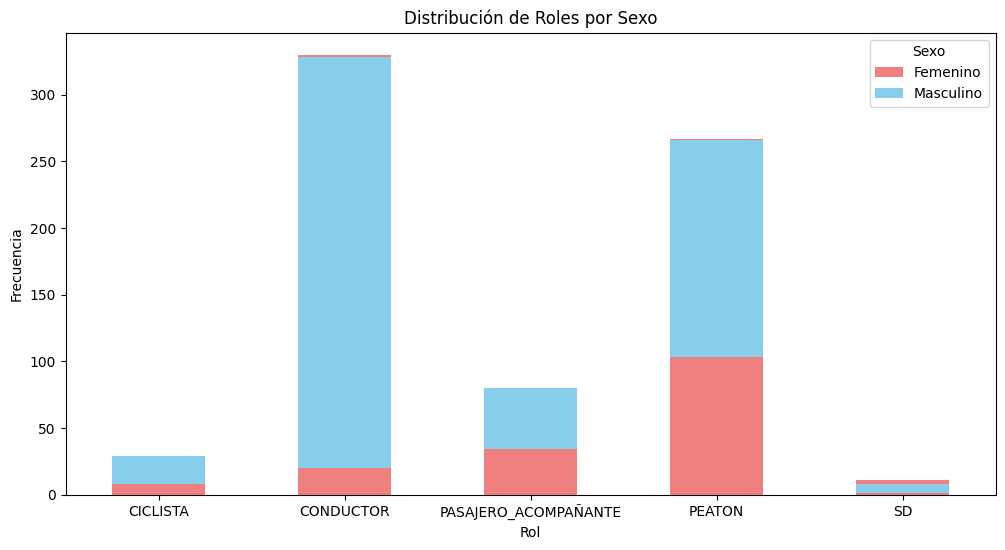

In [36]:
# Crear una tabla de contingencia
tabla_contingencia = pd.crosstab(df['Rol'], df['Sexo'])

# Crear un gráfico de barras apiladas
ax = tabla_contingencia.plot(kind='bar', stacked=True, figsize=(12, 6), color=["lightcoral",'skyblue'])
plt.title('Distribución de Roles por Sexo')
plt.xlabel('Rol')
plt.ylabel('Frecuencia')

# Agregar una leyenda
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Femenino', 'Masculino'], title='Sexo')

plt.xticks(rotation=0)
plt.show()

__Conclusión__

La distribución por roles de las víctimas muestra que

- La mayor cantidad de siniestros las victimas tienen como rol Conductor, seguida por Peatón.
- Para las víctimas de sexo Masculino, el rol más frecuente en los siniestros es como conductor, seguido por peatón.
- Para las víctimas de sexo Femenino, el rol más frecuente en los siniestros es como peatón, seguido por pasajero-acompañante

__Distribucíon de víctimas según sexo y tipo de vehículo__

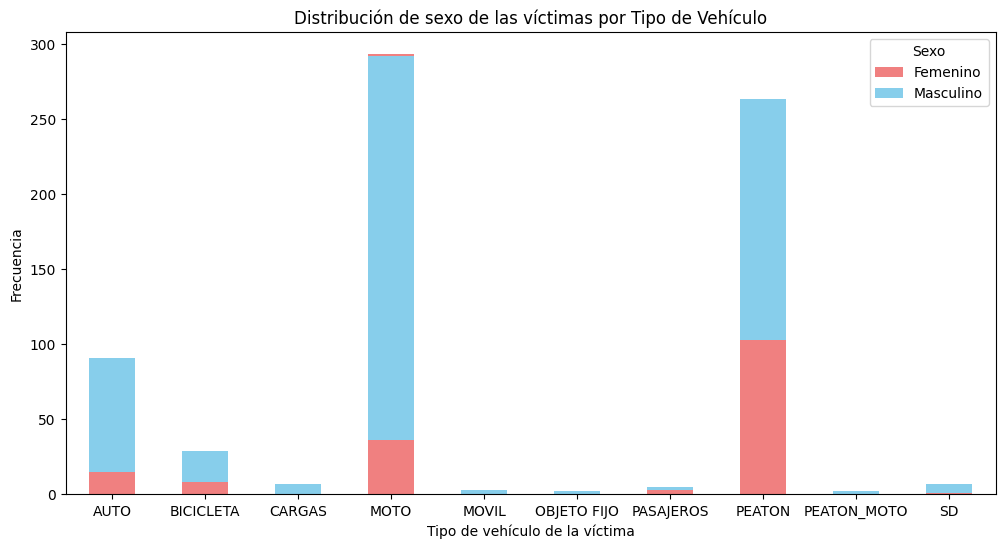

In [37]:
# Crear una tabla de contingencia
tabla_contingencia = pd.crosstab(df['Victima'], df['Sexo'])

# Crear un gráfico de barras apiladas
ax = tabla_contingencia.plot(kind='bar', stacked=True, figsize=(12, 6), color=["lightcoral",'skyblue'])
plt.title('Distribución de sexo de las víctimas por Tipo de Vehículo')
plt.xlabel('Tipo de vehículo de la víctima')
plt.ylabel('Frecuencia')

# Agregar una leyenda
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Femenino', 'Masculino'], title='Sexo')

plt.xticks(rotation=0)
plt.show()

__Conclusión__

- La mayor cantidad de accidentes con víctimas fatales son en Moto y además con más proporción de Masculinos
- Los Peatones, son el segundo tipo de víctima, en el que la mayor proporción son Masculinos pero con menor diferencia que en la primera.